In [143]:
import cv2
from PIL import Image, ImageEnhance, ImageDraw
import matplotlib.pyplot as plt

from pdf2image import convert_from_path
import pytesseract

import glob
import numpy as np
import pandas as pd
import regex as re
import warnings
warnings.filterwarnings('ignore')

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
poppler_path = r'D:\Users\chelsy.mena\Downloads\poppler-22.04.0\Library\bin'


In [2]:
informes = glob.glob(r'D:\Users\chelsy.mena\OneDrive - Centro de Servicios Mundial SAS\Documentos\Proyectos\HSE\Residuos\Remisiones Julio\*')


In [234]:
def delinear_pdf(archivo):

    # Cargar un PDF
    paginas = convert_from_path(pdf_path=archivo, poppler_path=poppler_path)

    # Convertir pagina a blanco y negro
    imagen = paginas[0].convert('L')

    # Encontrar las lineas
    ## Pasar a array de numpy
    img = np.array(imagen)

    ## Quitar fondo e invertir colores
    th, threshed = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
    threshed = cv2.morphologyEx(threshed, cv2.MORPH_OPEN, np.ones((1, 3), np.uint8)) 
    threshed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, np.ones((20, 1), np.uint8))

    # Juntar lo que es texto en un cuadrito blanco
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    dilate = cv2.dilate(threshed, kernel, iterations=4)

    ## (5) Encontrar los bordes superiores e inferiores de las lineas
    hist = cv2.reduce(dilate, 1, cv2.REDUCE_AVG).reshape(-1)

    th = 2
    H, W = img.shape[:2]
    uppers = [y for y in range(H-1) if hist[y]<=th and hist[y+1]>th]
    lowers = [y for y in range(H-1) if hist[y]>th and hist[y+1]<=th]

    # Dibujar los Bordes en la Imagen
    img1 = ImageDraw.Draw(imagen)
    for i in range(len(uppers)):  
        img1.line([(0, uppers[i]), (1600, uppers[i])], fill ="red", width = 0)
        img1.line([(0, lowers[i]), (1600, lowers[i])], fill ="red", width = 0)
    for x in [0, 392, 590, 785, 915, 1055, 1600]:
        img1.line([(x, 0), (x, 2000)], fill ="red", width = 0)

    return imagen, uppers, lowers

def replicar_tabla(imagen, uppers, lowers, archivo):

    # crear Tabla para guardar ahi
    tabla = pd.DataFrame({'GUIA':[],
                          'RESIDUO': [],
                          'ESTADO FÍSICO': [],
                          'EMBALAJE': [],
                          'RECOGIDO':[],
                          'UNIDADES':[],
                          'TIPOLOGÍA':[]})
    
    # Cortar por linea
    for i in range(8, len(uppers)):
        area = (0, uppers[i]-5, 1600, lowers[i]+5)
        #cropped = Image.fromarray(np.uint8(img)).crop(area)
        cropped = imagen.crop(area)
        text = pytesseract.image_to_string(cropped)

        # Parar cuando termina la tabla de residuos
        if 'CONSTANCIA' in text:
                break
        else:
            # Partir verticalmente
            limites = [0, 392, 590, 785, 915, 1055, 1600]
            linea = [re.sub('\D*', '', re.escape(archivo))] # Sacar el No de Guia del nombre de archivo

            for i in range(1, len(limites)):
                area = (limites[i-1], 0, limites[i], cropped.size[1])
                cropped_celda = cropped.crop(area)

                text = pytesseract.image_to_string(cropped_celda)
                linea.append(text.replace("\n", ""))
            
            tabla.loc[tabla.shape[0]+1] = linea

    return tabla

In [235]:
archivo = informes[0]
imagen, lims_sup, lims_inf = delinear_pdf(archivo)
remisiones = replicar_tabla(imagen, lims_sup, lims_inf, archivo)

for archivo in informes[1:]:
    if '.pdf' in archivo:
        print("Procesando Remisión N° " + re.sub('\D*', '', re.escape(archivo)))
        imagen, lims_sup, lims_inf = delinear_pdf(archivo)
        tabla = replicar_tabla(imagen, lims_sup, lims_inf, archivo)
        remisiones = pd.concat([remisiones, tabla])

['574151', 'LODOS DE PTAR', 'SOLIDO', 'BIG BAGS', '8.600,00KILOGRAMOS', '19', 'ORDINARIOS KG']
Procesando Remisión N° 576853
['576853', 'LODOS DE PTAR', 'SOLIDO', 'BIG BAGS', '14.600,00KILOGRAMOS', '22', 'ORDINARIOS KG']
Procesando Remisión N° 580456
['580456', 'LODOS DE PTAR', 'SEMISOLIDO', 'BIG BAGS', '14.830,00KILOGRAMOS', '22', 'ORDINARIOS KG']
Procesando Remisión N° 580457
['580457', 'LODOS DE PTAR', 'SEMISOLIDO', 'BIG BAGS', '14.370,00KILOGRAMOS', '18', 'ORDINARIOS KG']
Procesando Remisión N° 581453
['581453', 'ACEITE MINERAL', 'LIQUIDO', 'CANECA', '200,00 KILOGRAMOS', '', 'DISPOSICION DIRECTA']
['581453', 'FIBRA DE VIDRIO - ALTO VOLUMEN', 'SOLIDO', 'CANECA', '350,00 KILOGRAMOS', '', 'DISPOSICION DIRECTA -ALTO VOLUMEN']
['581453', 'FRASCOS Y EMPAQUESCONTAMINADOS CON PRODUCTOSQUIMICOS', 'SOLIDO', 'BOLSA', '1.380,00KILOGRAMOS', '', 'DISPOSICION DIRECTA']
['581453', 'RESIDUO DE FILTRACION DEEMULSIONES', 'SEMISOLIDO', 'CANECA', '2.902,00KILOGRAMOS', '', 'DISPOSICION DIRECTA']
['58145

In [236]:
remisiones

,GUIA,RESIDUO,ESTADO FÍSICO,EMBALAJE,RECOGIDO,UNIDADES,TIPOLOGÍA
1,574151,LODOS DE PTAR,SOLIDO,BIG BAGS,"8.600,00KILOGRAMOS",19,ORDINARIOS KG
1,576853,LODOS DE PTAR,SOLIDO,BIG BAGS,"14.600,00KILOGRAMOS",22,ORDINARIOS KG
1,580456,LODOS DE PTAR,SEMISOLIDO,BIG BAGS,"14.830,00KILOGRAMOS",22,ORDINARIOS KG
1,580457,LODOS DE PTAR,SEMISOLIDO,BIG BAGS,"14.370,00KILOGRAMOS",18,ORDINARIOS KG
1,581453,ACEITE MINERAL,LIQUIDO,CANECA,"200,00 KILOGRAMOS",,DISPOSICION DIRECTA
2,581453,FIBRA DE VIDRIO - ALTO VOLUMEN,SOLIDO,CANECA,"350,00 KILOGRAMOS",,DISPOSICION DIRECTA -ALTO VOLUMEN
3,581453,FRASCOS Y EMPAQUESCONTAMINADOS CON PRODUCTOSQU...,SOLIDO,BOLSA,"1.380,00KILOGRAMOS",,DISPOSICION DIRECTA
4,581453,RESIDUO DE FILTRACION DEEMULSIONES,SEMISOLIDO,CANECA,"2.902,00KILOGRAMOS",,DISPOSICION DIRECTA
5,581453,RESIDUO IND. VARIOSCONTAMINADOS 331205,SEMISOLIDO,CANECA,"2.240,00KILOGRAMOS",,ESTABILIZACION
1,581454,POLIMEROS EN SOLUCION,LIQUIDO,CANECA,"105,00 KILOGRAMOS",,ESTABILIZACION


In [230]:
archivo = informes[3]
imagen, lims_sup, lims_inf = delinear_pdf(archivo)

In [171]:
foto = Image.fromarray(np.uint8(imagen)).convert('RGB')

In [222]:
img1 = ImageDraw.Draw(imagen)
for i in range(len(lims_sup)):  
    img1.line([(0, lims_sup[i]), (1600, lims_sup[i])], fill ="red", width = 0)
    img1.line([(0, lims_inf[i]), (1600, lims_inf[i])], fill ="red", width = 0)
for x in [0, 392, 590, 785, 915, 1055, 1600]:
    img1.line([(x, 0), (x, 2000)], fill ="red", width = 0)
    
imagen.show()

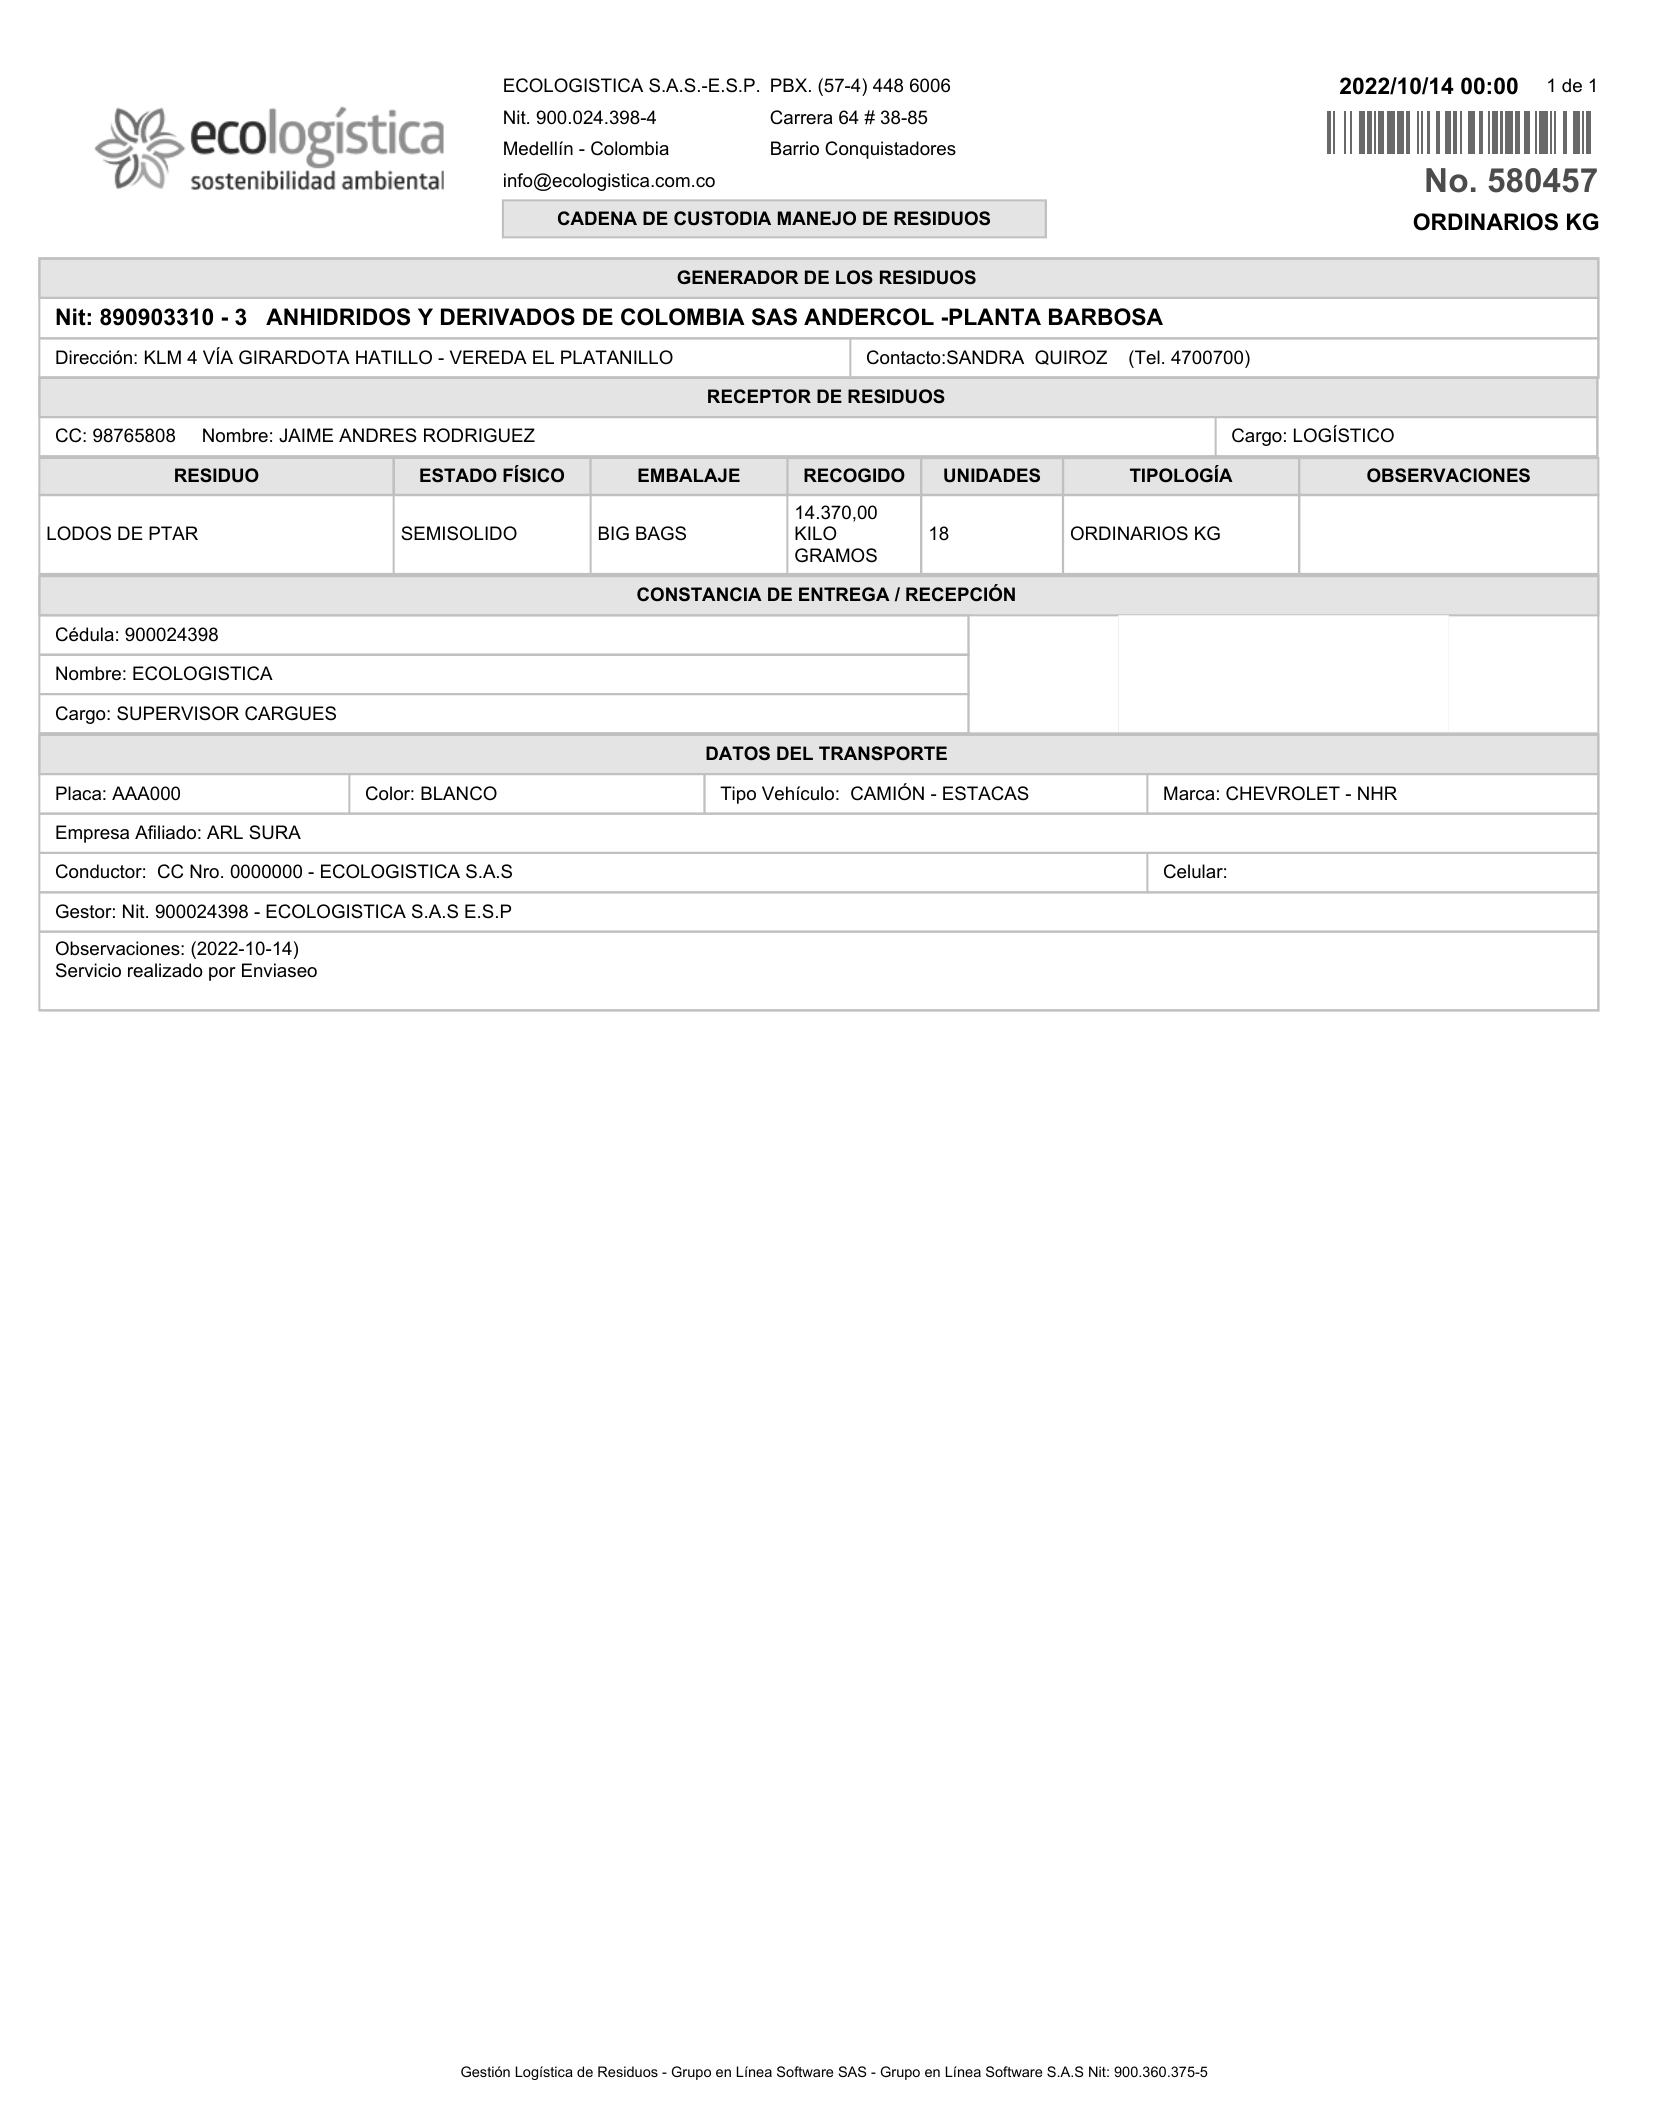

In [231]:
imagen

In [232]:
limites = [0, 392, 590, 785, 915, 1055, 1600]

for i in range(8, 9):
    area = (0, lims_sup[i]-5, 1600, lims_inf[i]+5)
    #cropped = Image.fromarray(np.uint8(img)).crop(area)
    cropped = imagen.crop(area)

    linea = [re.sub('\D*', '', re.escape(archivo))]
    for i in range(1, len(limites)):
        area = (limites[i-1], 0, limites[i], cropped.size[1])
        cropped_celda = cropped.crop(area)
        
        text = pytesseract.image_to_string(cropped_celda)
        print(text)
        linea.append(text.replace("\n", ""))
linea

LODOS DE PTAR

SEMISOLIDO

BIG BAGS

14.370,00
KILO
GRAMOS


ORDINARIOS KG



['580457',
 'LODOS DE PTAR',
 'SEMISOLIDO',
 'BIG BAGS',
 '14.370,00KILOGRAMOS',
 '',
 'ORDINARIOS KG']

In [209]:
area = (limites[i-1], 0, limites[i], cropped.size[1])
cropped_celda = imagen.crop(area)

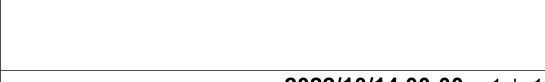

In [210]:
cropped_celda